<a href="https://colab.research.google.com/github/ohilikeit/Statistics_competition/blob/main/%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 367 kB/s 
     |████████████████████████████████| 448 kB 80.7 MB/s 


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.30.254.90:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.30.254.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.30.254.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from konlpy.tag import Okt
import os
import json
import random
import pickle
import re
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

# 1. Data load

In [ ]:
raw_data = pd.read_table('/content/drive/MyDrive/StatisticCompetition/train.txt',sep='|', encoding='cp949')
submit_data = pd.read_table('/content/drive/MyDrive/StatisticCompetition/2. 모델개발용자료.txt',sep='|', encoding='cp949')

def preprocess(raw_data):  # 텍스트를 하나로 합친다. 
    data = raw_data.copy()
    data = data.replace(np.nan, '', regex=True)        # NA가 존재하는 행 없애는 용도
    data = data.rename(columns={'digit_3':'label'})    # 타깃 변수명 변경
    data['document'] = data['text_obj'] + ' ' + data['text_mthd'] + ' ' + data['text_deal']  
    data = data.drop(['text_mthd', 'text_deal', 'text_obj', 'AI_id'], axis=1)

    data = data.dropna()
    data = data.reset_index(drop=True)

    return data

data = preprocess(raw_data)
submit = preprocess(submit_data)

,digit_1,digit_2,label,document
0,S,95,952,카센터에서 자동차부분정비 타이어오일교환
1,G,47,472,상점내에서 일반인을 대상으로 채소.과일판매
2,G,46,467,절단하여사업체에도매 공업용고무를가지고 합성고무도매
3,G,47,475,영업점에서 일반소비자에게 열쇠잠금장치
4,Q,87,872,어린이집 보호자의 위탁을 받아 취학전아동보육
...,...,...,...,...
999995,C,13,134,제품입고 워싱 청바지워싱
999996,F,42,424,현장에서 고객의요청에의해 실내인테리어
999997,G,47,474,영업점에서 일반소비자에게 여성의류 판매
999998,P,85,856,사업장에서 일반고객을대상으로 필라테스


# 2. EDA


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


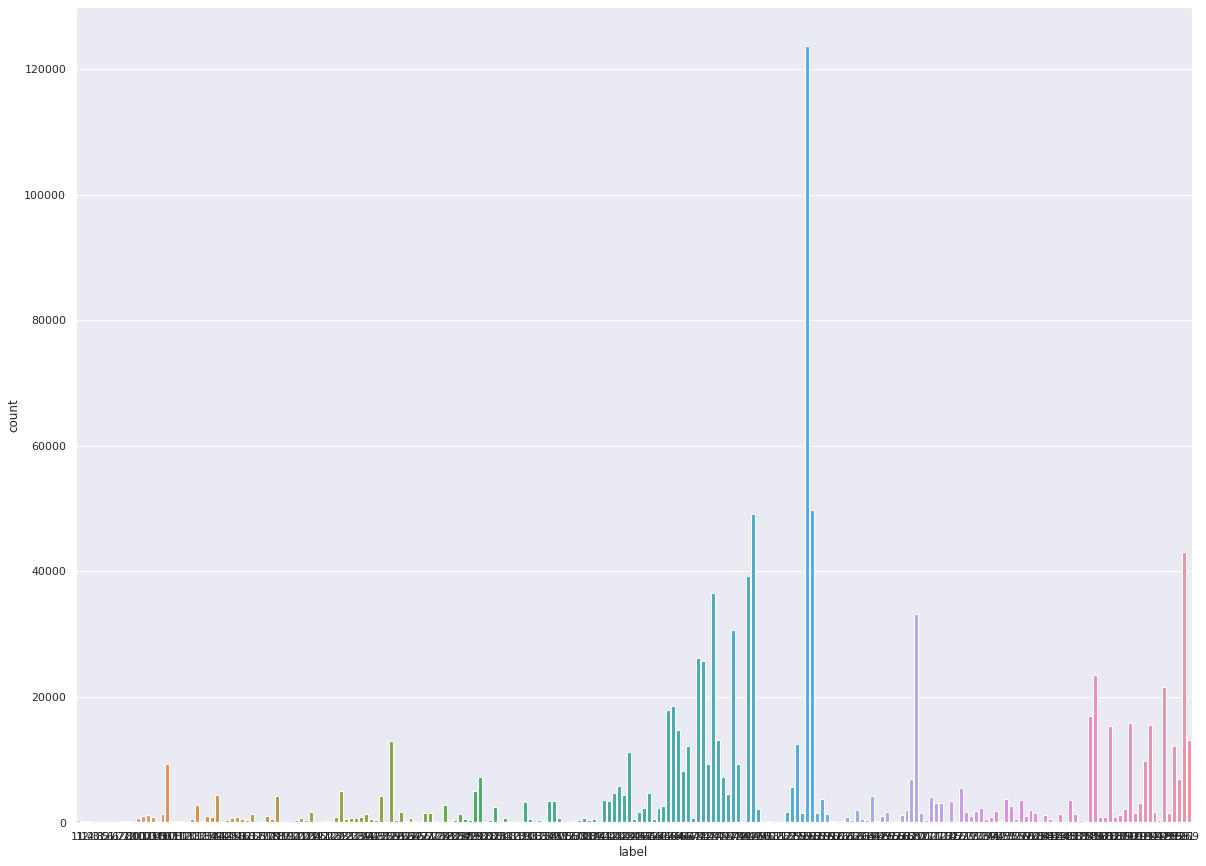

In [ ]:
# class 별 데이터 수 확인
import seaborn as sns
sns.set(rc = {'figure.figsize':(20,15)})
sns.countplot(data['label'])

- label에 해당하는 digit_3의 분포를 확인해보니 클래스 불균형 문제가 심각하다.
- 분석법은 데이터의 균등분포를 가정하기에 이를 해결해주어야 한다. 또한 정확도가 높게 나오더라도 새로운 데이터에 대해선 쓸모없는 모델이 될 가능성이 높다.
- 100개 중 라벨 1이 97개이고 라벨 2가 3개이면, 모든 라벨을 1로 예측해도 97%의 정확도가 나오기 때문이다.
- 따라서 class에 weight를 주고 적은 수를 가진 라벨의 데이터를 SMOTE 기법을 사용하여 늘려주겠다.

# 3. Preprocessing

## 1) Easy Data Augmentation

In [ ]:
wordnet = {}
with open("/content/drive/MyDrive/StatisticCompetition/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# EDA
########################################################################

def EDA(sentence, alpha_sr=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):  
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/3) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_rs = max(1, int(alpha_rs*num_words))
 
	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))
  
	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [sentence for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

In [ ]:
# 500개 이하인 라벨 데이터만 가져오기 
df = pd.DataFrame(data['label'].value_counts() <= 500)          
idx = df[df['label'] == True].index.tolist()
df_2 = data[data['label'].isin(idx)]

# result 리스트에 라벨 당 3개의 추가적인 문장 생성
result = []
for i in tqdm(range(len(df_2))):
    result.append(EDA(df_2.document.iloc[i]))  

# 데이터프레임으로 변경
add_data = pd.DataFrame(columns=['document'])
for i in range(len(result)):
    add_data = add_data.append(pd.DataFrame(result[i], columns=['document']))

# 순서쌍 가져와서 맞춰주기 
digit_1 = []
digit_2 = []
labelist = []

idx_list = df_2['label'].tolist()
for i in range(len(idx_list)):
    index_1 = data[data['label'] == idx_list[i]][:1]['digit_1']
    digit_1.append(np.repeat(index_1,5))

    index_2 = data[data['label'] == idx_list[i]][:1]['digit_2']
    digit_2.append(np.repeat(index_2,5))

    labelist.append(np.repeat(idx_list[i],5))

digit_1_data = pd.DataFrame(np.array(digit_1).flatten().tolist(), columns=['digit_1'])
digit_2_data = pd.DataFrame(np.array(digit_2).flatten().tolist(), columns=['digit_2'])
labelist_data = pd.DataFrame(np.array(labelist).flatten().tolist(), columns=['label'])

add_data.reset_index(inplace=True, drop=True)
adding = pd.concat([digit_1_data, digit_2_data, labelist_data, add_data], axis=1)
print(adding)

# 원본 데이터에 붙이기
data = data.append(adding, ignore_index=True)
print(data)     # 총 74,300개의 데이터 증강을 완료하였다.

100%|██████████| 14860/14860 [00:01<00:00, 13818.48it/s]


      digit_1  digit_2  label                    document
0           C       20    203   님박, 골분, 어분 각종 혼합.발효 비료 제조
1           C       20    203   혼합.발효 골분, 어분 님박, 각종 비료 제조
2           C       20    203    님박, 골분, 어분 혼합.발효 각종 거 제조
3           C       20    203   님박, 골분, 어분 혼합.발효 각종 비료 제조
4           C       20    203  님박, 골분, 어분 혼합.발효 각종 비료  제조
...       ...      ...    ...                         ...
74295       J       59    592                     녹음시설운영업
74296       J       59    592                     녹음시설운영업
74297       J       59    592                     녹음시설운영업
74298       J       59    592                     녹음시설운영업
74299       J       59    592                    녹음시설운영업 

[74300 rows x 4 columns]
        digit_1  digit_2  label                     document
0             S       95    952        카센터에서 자동차부분정비 타이어오일교환
1             G       47    472      상점내에서 일반인을 대상으로 채소.과일판매
2             G       46    467  절단하여사업체에도매 공업용고무를가지고 합성고무도매
3             G       47    475   

## 2) Tokenizing

In [ ]:
# train, test셋 분리
X_train, X_test, label_train, label_test = train_test_split(data['document'], data['label'], test_size=0.1, random_state=42, stratify=data['label'])

stop_words = pd.read_table('/content/drive/MyDrive/StatisticCompetition/Korean_stopwords.txt',sep='\n')
stop_word = stop_words.values
okt = Okt()

def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    # text : 전처리할 텍스트
    # okt : 객체 반복생성하지 않고 미리 생성한 후 인자로 받는다.
    # remove_stopword : 불용어 제거 여부, default는 False
    # stop_word : 불용어 사전

    text_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)  # 한글, 공백 제외 문자 모두 제거 
    word_text = okt.morphs(text_text)                       # okt 객체 활용, 형태소 단위로 나누기 
    if remove_stopwords == True:
        word_texts = [token for token in word_text if not token in stop_words]

    return word_texts

In [ ]:
clean_train_text = []
for text in tqdm(X_train):
    clean_train_text.append(preprocessing(text, okt, remove_stopwords=True,stop_words=stop_word))

clean_train_text[:4]

100%|██████████| 966870/966870 [1:37:40<00:00, 164.99it/s]


[['인터넷', '신문', '인터넷', '뉴스', '인', '뉴스'],
 ['개인', '택시', '일반인', '대상', '승객', '운송', '서비스'],
 ['사무실', '업체', '기관', '산학', '협력', '지원', '서비스'],
 ['식당', '접객', '시설', '갖추고', '소', '돼지고기', '구이']]

In [ ]:
clean_test_text = []
for text in tqdm(X_test):
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True,stop_words=stop_word))

clean_test_text[:4]

100%|██████████| 107430/107430 [14:56<00:00, 119.81it/s]


[['건설', '현장', '조', '경', '시설', '시공', '시공'],
 ['연구실', '물리', '화학생물학', '연구', '결과', '제공'],
 ['유리', '사업', '장', '박판', '유리', '보호', '코팅', '제품'],
 ['사업', '장', '유해', '폐기물', '소각', '장', '소', '지정', '폐기물', '처리']]

In [ ]:
clean_submit_text = []
for text in tqdm(submit['document']):
        clean_submit_text.append(preprocessing(text, okt, remove_stopwords=True,stop_words=stop_word))

clean_submit_text[:5]

[['치킨', '전문점', '고객', '주문', '에의', '해', '치킨', '판매'],
 ['산업', '공구', '소매업자', '철물', '공구'],
 ['절', '신도을', '대상', '불교', '단체', '운영'],
 ['영업', '장', '고객', '요구', '자동차튜닝'],
 ['실내', '포장마차', '접객', '시설', '갖추고', '소주', '맥주', '제공']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_text)
tokenizer.fit_on_texts(clean_test_text)
tokenizer.fit_on_texts(clean_submit_text)

train_sequences = tokenizer.texts_to_sequences(clean_train_text)
test_sequences = tokenizer.texts_to_sequences(clean_test_text)
submit_sequences = tokenizer.texts_to_sequences(clean_submit_text)

word_vocab = tokenizer.word_index # 단어 사전 형태, vocab_size = 39990 + 1 = 39991
# len(tokenizer.word_index)

MAX_SEQUENCE_LENGTH = 30

train_input = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')      # 학습 데이터 벡터화
train_label = np.array(label_train)                                                           # 학습 데이터 라벨 
test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')        # 평가 데이터 벡터화
test_label = np.array(label_test)                                                             # 평가 데이터 라벨 
submit_input = pad_sequences(submit_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')    # submit 데이터 벡터화

''' max_length 확인법
wow = []
for i in range(len(train_sequences)):
    wow.append(len(train_sequences[i]))
max(wow)
'''

' max_length 확인법\nwow = []\nfor i in range(len(train_sequences)):\n    wow.append(len(train_sequences[i]))\nmax(wow)\n'

# 4. modeling

## 1) 데이터 불균형 해소 -  class_weight

In [ ]:
# 데이터 로드
DATA_IN_PATH = '/content/drive/MyDrive/StatisticCompetition/oktmorphs/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))

prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [ ]:
# 클래스 별 가중치 생성 함수 
def get_class_weights(labels, one_hot=False):
        if one_hot is False:
            n_classes = max(labels) + 1
        else:
            n_classes = len(labels[0])
        class_counts = [0 for _ in range(int(n_classes))]
        if one_hot is False:
            for label in labels:
                class_counts[label] += 1
        else:
            for label in labels:
                class_counts[label.index(1)] += 1
        return {i : (1. / class_counts[i]) * float(len(labels)) / float(n_classes) for i in range(int(n_classes))}


cate_train_labels = np.array(pd.get_dummies(train_label).values)      # 라벨 원-핫 인코딩

listed_train_labels = cate_train_labels.tolist()                        # 인코딩 라벨 리스트로 변환(함수 이용 목적)
class_weights = get_class_weights(listed_train_labels, one_hot=True)    # 클래스 별 weight 생성 

## 2) 데이터 분리

In [ ]:
# train 셋에서 검증셋 분리 
x_train, x_val, y_train, y_val = train_test_split(train_input,
                                                  cate_train_labels,
                                                  test_size=0.1,
                                                  random_state=42, 
                                                  shuffle=True, 
                                                  stratify=cate_train_labels)

100%|██████████| 4/4 [00:00<00:00, 41734.37it/s]


## 3) 모델링 및 학습

In [ ]:
# 데이터 로드 
x_train = np.load('/content/drive/MyDrive/StatisticCompetition/oktmorphs/x_train.npy')
x_val = np.load('/content/drive/MyDrive/StatisticCompetition/oktmorphs/x_val.npy')
y_train = np.load('/content/drive/MyDrive/StatisticCompetition/oktmorphs/y_train.npy')
y_val = np.load('/content/drive/MyDrive/StatisticCompetition/oktmorphs/y_val.npy')
raw_data = pd.read_table('/content/drive/MyDrive/StatisticCompetition/train.txt',sep='|', encoding='cp949')

In [ ]:
# 하이퍼파라미터 설정
initializer = tf.keras.initializers.HeNormal(seed=42)   # 가중치 초기화 설정 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  
                                                 factor=0.2,         # callback 호출 시 lr 0.2 줄임 
                                                 patience=5,         # 5 epoch 동안 변화 없을 시 callback 호출 3으로 줄여보장 대신 factor 0.3으로 
                                                 min_delta = 0.01,   # 개선을 위한 최소 변화량 
                                                 mode='auto',
                                                 verbose=1)
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, restore_best_weights=True)   
mc = ModelCheckpoint('/content/drive/MyDrive/StatisticCompetition/oktmorphs/best_model_4.h5', monitor='val_loss', mode='auto', save_best_only=True)
act_func = tf.keras.layers.ELU(alpha=1.0)


def create_model():
    input = tf.keras.layers.Input(shape=(30,))   
    net = tf.keras.layers.Embedding(input_dim=39991, output_dim=1024)(input)    

    net = tf.keras.layers.Conv1D(filters=1024, kernel_size=3, strides=1, padding='same', activation=act_func)(net) 
    net = tf.keras.layers.BatchNormalization()(net)       # 약간의 드롭아웃 효과가 있음    
    net = tf.keras.layers.GlobalMaxPooling1D()(net)

    net = tf.keras.layers.Flatten()(net)  
                                                    
    net = tf.keras.layers.Dense(units=256, activation=act_func,kernel_initializer=initializer)(net)   # 가중치 초기화, 출력층의 노드 수보다 커야 병목현상이 안일어남. 동시에 오버피팅 방지를 위해 가능한 노드 수를 줄임.    
    net = tf.keras.layers.Dropout(0.5)(net)             
    net = tf.keras.layers.Dense(units=225, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(net)              # 출력층, L2 규제 정규화                 
    model = tf.keras.models.Model(input, net)                                                     

    return model

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)
with tpu_strategy.scope():
    model = create_model()

    model.compile(loss='categorical_crossentropy',
              optimizer=opt,  
              metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                    epochs=200,
                    validation_data=(x_val,y_val),
                    batch_size=512,                     
                    callbacks=[mc, reduce_lr, earlystop_callback],
                    class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
1700/1700 [==============================] - 78s 41ms/step - loss: 1.9621 - accuracy: 0.7192 - val_loss: 0.6990 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/200
1700/1700 [==============================] - 63s 37ms/step - loss: 0.8569 - accuracy: 0.8405 - val_loss: 0.6469 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 3/200
1700/1700 [==============================] - 61s 36ms/step - loss: 0.6707 - accuracy: 0.8596 - val_loss: 0.5577 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 4/200
1700/1700 [==============================] - 60s 35ms/step - loss: 0.5922 - accuracy: 0.8705 - val_loss: 0.5186 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 5/200
1700/1700 [==============================] - 56s 33ms/step - loss: 0.4993 - accuracy: 0.8851 - val_loss: 0.5307 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 6/200
1700/1700 [==============================] - 58s 34ms/step - loss: 0.4548 - accuracy: 0.8909 - val_loss: 0.5141 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 7/200
1700/1700 [=================

## 4) 학습 곡선 확인 및 test셋 검증

In [ ]:
# 모델 학습 후 정보가 담긴 history 내용을 토대로 선 그래프를 그리는 함수 설정

def plot_acc(history, title=None):        # Accuracy(정확도) Visualization
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])        # accuracy
    plt.plot(history['val_accuracy'])    # validation accuracy
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def plot_loss(history, title=None):     # Loss Visualization
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])           # loss
    plt.plot(history['val_loss'])       # validation
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

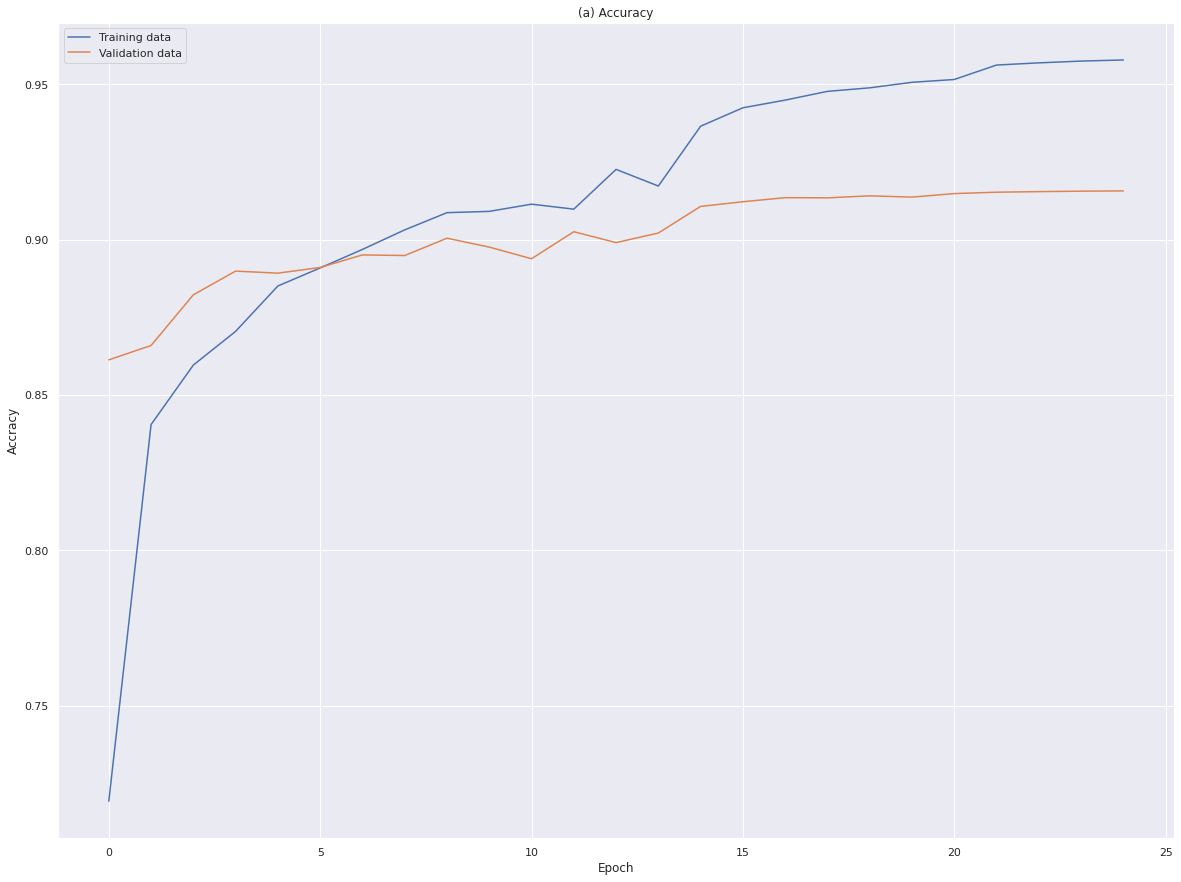

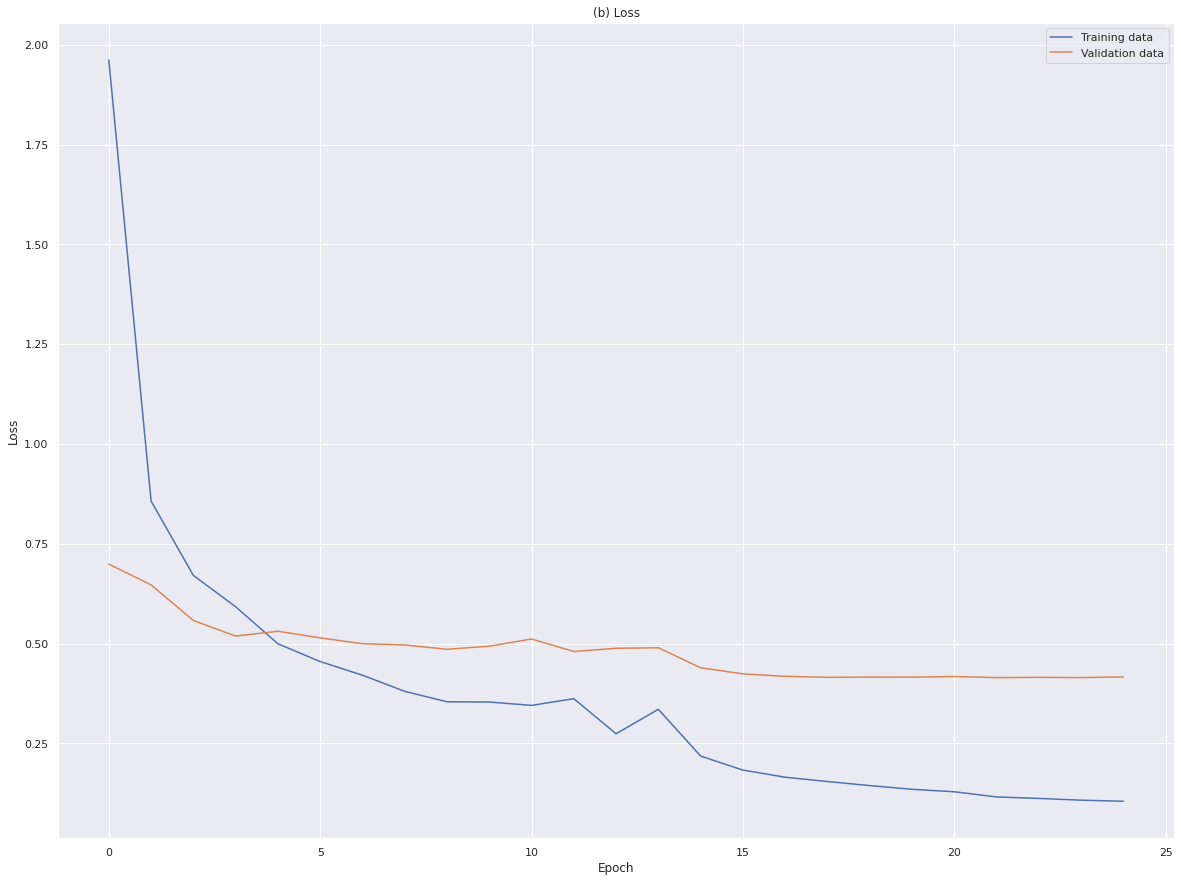

In [ ]:
plot_acc(history, '(a) Accuracy')  # 학습 경과에 따른 정확도 변화 추이
plt.show()
plot_loss(history, '(b) Loss')     # 학습 경과에 따른 손실값 변화 추이
plt.show()

In [ ]:
# test셋으로 확인해보기 
# test 데이터 불러오기
DATA_IN_PATH = '/content/drive/MyDrive/StatisticCompetition/oktmorphs/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름
test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [ ]:
cate_y_test = np.array(pd.get_dummies(test_label).values)
# best_model 불러오기
from tensorflow.keras.models import load_model
model_saved = load_model('/content/drive/MyDrive/StatisticCompetition/oktmorphs/best_model_4.h5')

# 라벨 인덱스 구하기 
labels = pd.DataFrame(test_label)
sorted_labels = np.sort(labels[0].unique())  # 정렬된 라벨들 225개 
len(sorted_labels)
# test셋에 대한 예측 
y_predict = model_saved.predict(test_input)
final_label = []    # 예측한 라벨

for i in range(len(y_predict)):
    index = sorted_labels[y_predict[i].argmax()]
    index2 = y_predict[i][y_predict[i].argmax()]
    final_label.append(index)

from sklearn.metrics import f1_score
print('macro ', f1_score(test_label, final_label, average='macro'))

macro  0.8586710180048754


## 5) 제출

In [ ]:
# 제출
DATA_IN_PATH = '/content/drive/MyDrive/StatisticCompetition/oktmorphs/'
INPUT_SUBMIT_DATA = 'nsmc_submit_input.npy'
submit_input = np.load(open(DATA_IN_PATH + INPUT_SUBMIT_DATA, 'rb'))

In [ ]:
# 라벨 인덱스 구하기 
labels = pd.DataFrame(train_input)
sorted_labels = np.sort(labels[0].unique())  # 정렬된 라벨들 225개 

# submit용 예측하기 
submit_predict = model_saved.predict(submit_input)
submit_label = []                                   # 제출용 라벨
for i in range(len(submit_predict)):
    index = sorted_labels[submit_predict[i].argmax()]
    submit_label.append(index)


# 제출 파일 작성 
submission_file = pd.read_csv('/content/drive/MyDrive/StatisticCompetition/답안 작성용 파일.csv', encoding = 'cp949')
submission_file['digit_3'] = submit_label
sequences = raw_data[['digit_1', 'digit_2', 'digit_3']]
sequences = sequences.drop_duplicates()                      # 순서쌍 가져오기 
final = pd.merge(submission_file, sequences, on='digit_3', how = 'left')
final = final.drop(['digit_1_x', 'digit_2_x'], axis=1)
final.rename(columns={'digit_1_y':'digit_1',
                      'digit_2_y': 'digit_2'}, inplace=True)
final = final[['AI_id', 'digit_1', 'digit_2', 'digit_3', 'text_obj', 'text_mthd', 'text_deal']]
final.to_csv('/content/drive/MyDrive/StatisticCompetition/oktmorphs/submission.csv', encoding='cp949', index=False)
print(final)

# 5. References
- https://yeomko.tistory.com/39
- https://github.com/catSirup/KorEDA/tree/master
- http://www.smartdesignlab.org/DL/%EC%8B%A0%EA%B8%B0%EC%88%A0/CNN(sequential)_model_fit.html
- https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
- (텐서플로2와 머신러닝으로 시작하는) 자연어 처리 : 로지스틱 회귀부터 BERT와 GPT2까지 / 전창욱 / 2020 / 위키북스
- 한국어 임베딩 : 자연어 처리 모델의 성능을 높이는 핵심 비결 Word2Vec에서 ELMo, BERT까지 / 이기창 / 2019 / 에이콘출판

In [ ]:
print(pd.read_csv('/content/drive/MyDrive/StatisticCompetition/submission_kfold_1.csv', encoding='cp949'))

           AI_id digit_1  digit_2  digit_3  text_obj   text_mthd text_deal
0      id_000001       I       56      561   치킨전문점에서    고객의주문에의해      치킨판매
1      id_000002       G       47      475      산업공구   다른 소매업자에게    철물 수공구
2      id_000003       S       94      949       절에서    신도을 대상으로    불교단체운영
3      id_000004       S       96      961     영업장에서       고객요구로     자동차튜닝
4      id_000005       I       56      562  실내포장마차에서   접객시설을 갖추고   소주,맥주제공
...          ...     ...      ...      ...       ...         ...       ...
99995  id_099996       A        1       11     사업장에서     일반인대상으로      버섯농장
99996  id_099997       Q       86      862     한의원에서     외래환자위주고        치료
99997  id_099998       G       47      478    일반점포에서       소비자에게      그림판매
99998  id_099999       R       90      902     사업장에서  일반인.학생대상으로    학습공간제공
99999  id_100000       L       68      682     사업장에서    대리현대아파트를        관리

[100000 rows x 7 columns]
